In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from rnn.arch import RNN
from vae.arch import VAE

from os import listdir
from os.path import isfile, join

import cv2



Using TensorFlow backend.


In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


In [3]:
data = np.load('./data/rnn_input_car_racing_valid.npz')["arr_0"]
data = np.array([obs for obs in data])
# np.savez_compressed('./data/obs_valid', data[:600])

In [4]:
print(data.shape)


(59, 199, 35)


In [5]:
path = "./rnn/"
files = [f for f in listdir(path)  if f[-3:] == ".h5"]
files.sort()
dropdown = widgets.Dropdown(
    options=files,
    description='Weight file:',
)
display(dropdown)

Dropdown(description='Weight file:', options=('good_original.h5', 'good_simple.h5', 'weights.h5', 'weights_RNN…

In [6]:
rnn = RNN()
rnn.set_weights("./rnn/" + dropdown.value)
rnn.model.summary()
# rnn.forward.summary()

vae = VAE()
vae.set_weights("./vae/final.h5")
vae.decoder.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 35)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 300)         403200    
_________________________________________________________________
dense_1 (Dense)              (None, None, 32)          9632      
Total params: 412,832
Trainable params: 412,832
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              33792    

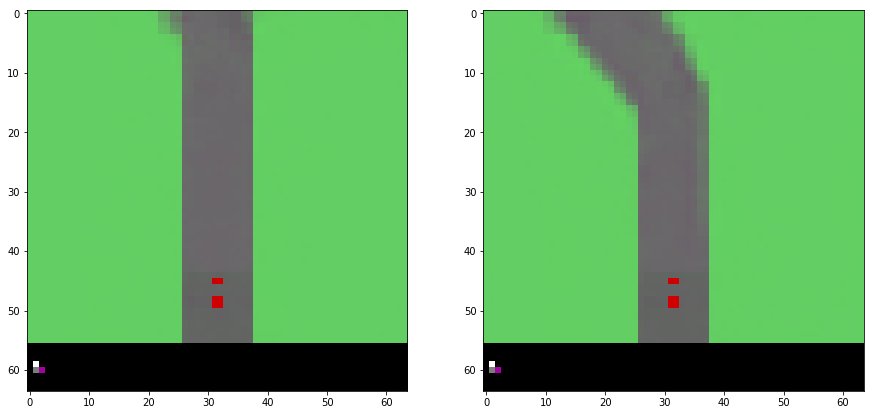

In [8]:
def compare_rnn(episode_index, frame_index, latency = 1):
    episode = data[episode_index]
    frames = episode[:frame_index]
    latents = frames[:, :-3]
#     print(latents.shape)
    img = vae.decoder.predict(latents)[-1]
#     print(img.shape)
#     print(frames.shape)
    for i in range(latency):
        next_latent = rnn.model.predict(x = np.expand_dims(frames, axis = 0))[0][-1]
        frames = np.append(frames, [np.append(next_latent, [1,0,0])], axis = 0)
    next_img = vae.decoder.predict(np.expand_dims(next_latent, axis = 0))[0]
#     print(next_img.shape)
    return img, next_img
 

f, axarr = plt.subplots(1, 2, figsize=(15,15))
left, right = compare_rnn(0, 10, 10)
axarr[0].imshow(left)
axarr[1].imshow(right)


In [9]:
def create_video(episode_index, latency):
    writer = cv2.VideoWriter("rnn_demo_"+ str(episode_index) + "_" + str(latency) + ".avi", 0, 30, (128, 64))

    for i in range(1, 199):
        left, right = compare_rnn(episode_index, i, latency)
        left = np.uint8(left[...,[2,1,0]] * 255)
        right = np.uint8(right[...,[2,1,0]] * 255)
        frame = np.append(left, right, axis = 1)
        writer.write(frame)
        writer.write(frame)

In [10]:
create_video(1, 11)

In [ ]:
#%%javascript
#Jupyter.notebook.session.delete();